# Enhancer code analysis

In this notebook we will go over how to obtain cell type characteristic sequence patterns from CREsted models, or any other model, using tfmodisco-lite.

## Obtaining contribution scores per model class and running tfmodisco-lite

Before we can do any analysis, we need to calculate the contribution scores for cell type-specific regions.
From those, we can run tfmodisco-lite.

### Load data and CREsted model

In [1]:
import os

os.environ["PATH"] = "/data/projects/c04/cbd-saerts/nkemp/tools:" + os.environ["PATH"]

In [6]:
import anndata
import crested

adata = anndata.read_h5ad("mouse_cortex_filtered.h5ad")

genome_file = "../../../../mouse/biccn/mm10.fa"
chrom_sizes = "../../../../mouse/biccn/mm10.chrom.sizes"
genome = crested.Genome(genome_file, chrom_sizes)
crested.register_genome(
    genome
)  # Register the genome so that it can be used by the package

2025-02-04T11:38:30.211063+0100 INFO Genome mm10 registered.


In [3]:
# load a trained model
import keras

model_path = "mouse_biccn/finetuned_model/checkpoints/02.keras"
model = keras.models.load_model(model_path, compile=False)  # change to your model path

2025-02-04 11:37:19.608289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78790 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:68:00.0, compute capability: 9.0


In [7]:
# store predictions for all our regions in the anndata object for later inspection.
predictions = crested.tl.predict(adata, model)
adata.layers["biccn_model"] = predictions.T  # adata expects (C, N) instead of (N, C)

I0000 00:00:1738665544.857746 3249199 service.cc:145] XLA service 0x7f020c00c9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738665544.857771 3249199 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-02-04 11:39:04.873901: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-04 11:39:04.969247: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  206/91475 ━━━━━━━━━━━━━━━━━━━━ 1:07 735us/step

I0000 00:00:1738665545.682699 3249199 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91475/91475 ━━━━━━━━━━━━━━━━━━━━ 67s 719us/step


### Select the most informative regions per cell type

To obtain cell type-characteristic patterns, we need to calculate contribution scores on highly specific regions. For this purpose, we've included a preprocessing function {func}`crested.pp.sort_and_filter_regions_on_specificity` to keep the top k most specific regions per cell type that you can use to filter your data before running modisco.

There are three options to select the top regions: either purely based on peak height, purely based on predictions, or on their combination. Here we show how to use the combination of both (which we recommend).

In [8]:
adata_combined = adata.copy()  # Copy the peak heights
adata_combined.X = (
    adata_combined.X + adata_combined.layers["biccn_model"]
) / 2  # Take the average with the predictions

In [16]:
# most informative regions per class
adata_filtered = adata_combined.copy()
top_k = 2000  # Here we take the top 2k most specific regions, but doing this on top 500 or top 1k will give similar results and will be faster to calculate
crested.pp.sort_and_filter_regions_on_specificity(
    adata_filtered, top_k=top_k, method="proportion"
)
adata_filtered

2025-02-04T11:48:51.471343+0100 INFO After sorting and filtering, kept 38000 regions.


/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 19 × 38000
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split', 'Class name', 'rank', 'proportion_score'
    obsm: 'weights'
    layers: 'biccn_model'

In [17]:
adata_filtered.var

chr      start        end  split Class name  \
region                                                                     
chr10:45499432-45501546    chr10   45499432   45501546    val      Astro   
chrX:23135863-23137977      chrX   23135863   23137977  train      Astro   
chr14:14264851-14266965    chr14   14264851   14266965  train      Astro   
chr1:127159287-127161401    chr1  127159287  127161401  train      Astro   
chr15:18236980-18239094    chr15   18236980   18239094  train      Astro   
...                          ...        ...        ...    ...        ...   
chr14:109213984-109216098  chr14  109213984  109216098  train        Vip   
chr3:93481374-93483488      chr3   93481374   93483488  train        Vip   
chr9:8248775-8250889        chr9    8248775    8250889   test        Vip   
chr1:70704410-70706524      chr1   70704410   70706524  train        Vip   
chr16:85306932-85309046    chr16   85306932   85309046  train        Vip   

                           rank  proportion_score  
region                                             
chr10:45499432-45501546       1          0.716959  
chrX:23135863-23137977        2          0.700491  
chr14:14264851-14266965       3          0.699784  
chr1:127159287-127161401      4          0.694755  
chr15:18236980-18239094       5          0.694676  
...                         ...               ...  
chr14:109213984-109216098  1996          0.240961  
chr3:93481374-93483488     1997          0.240937  
chr9:8248775-8250889       1998          0.240879  
chr1:70704410-70706524     1999          0.240873  
chr16:85306932-85309046    2000          0.240872  

[38000 rows x 7 columns]

### Calculating contribution scores per class

Now you can calculate the contribution scores for all the regions in your filtered anndata.  
By default, the contribution scores are calculated using the expected integrated gradients method, but you can change this to simple integrated gradients to speed up the calculation (this might result in less accurate scores).

In [ ]:
crested.tl.contribution_scores_specific(
    input=adata_filtered,
    target_idx=None,  # We calculate for all classes
    model=model,
    output_dir="modisco_results_ft_2000",
)

### Running tfmodisco-lite

When this is done, you can run TFModisco Lite on the saved contribution scores to find motifs that are important for the classification/regression task.  

You could use the tfmodisco package directly to do this, or you could use the {func}`crested.tl.modisco.tfmodisco` function which is essentially a wrapper around the tfmodisco package.

**Note that from here on, you can use contribution scores from any model trained in any framework, as this analysis just requires a set of one hot encoded sequences and contribution scores per cell type stored in the same directory.**

In [45]:
meme_db, motif_to_tf_file = crested.get_motif_db()

In [ ]:
# run tfmodisco on the contribution scores
crested.tl.modisco.tfmodisco(
    window=1000,
    output_dir="modisco_results_ft_2000",
    contrib_dir="modisco_results_ft_2000",
    report=True,  # Optional, will match patterns to motif MEME database
    meme_db="/home/VIB.LOCAL/niklas.kempynck/nkemp/tools/motifs.meme",  # File to MEME database
    max_seqlets=20000,
)

## Analysis of cell-type specific sequence patterns

Once you have obtained your modisco results, you can plot the the found patterns using the {func}`crested.pl.patterns.modisco_results` function.

2025-02-04T11:49:16.697738+0100 INFO Starting genomic contributions plot for classes: ['Astro', 'L5ET', 'Vip', 'Oligo']


/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages/crested/pl/_utils.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


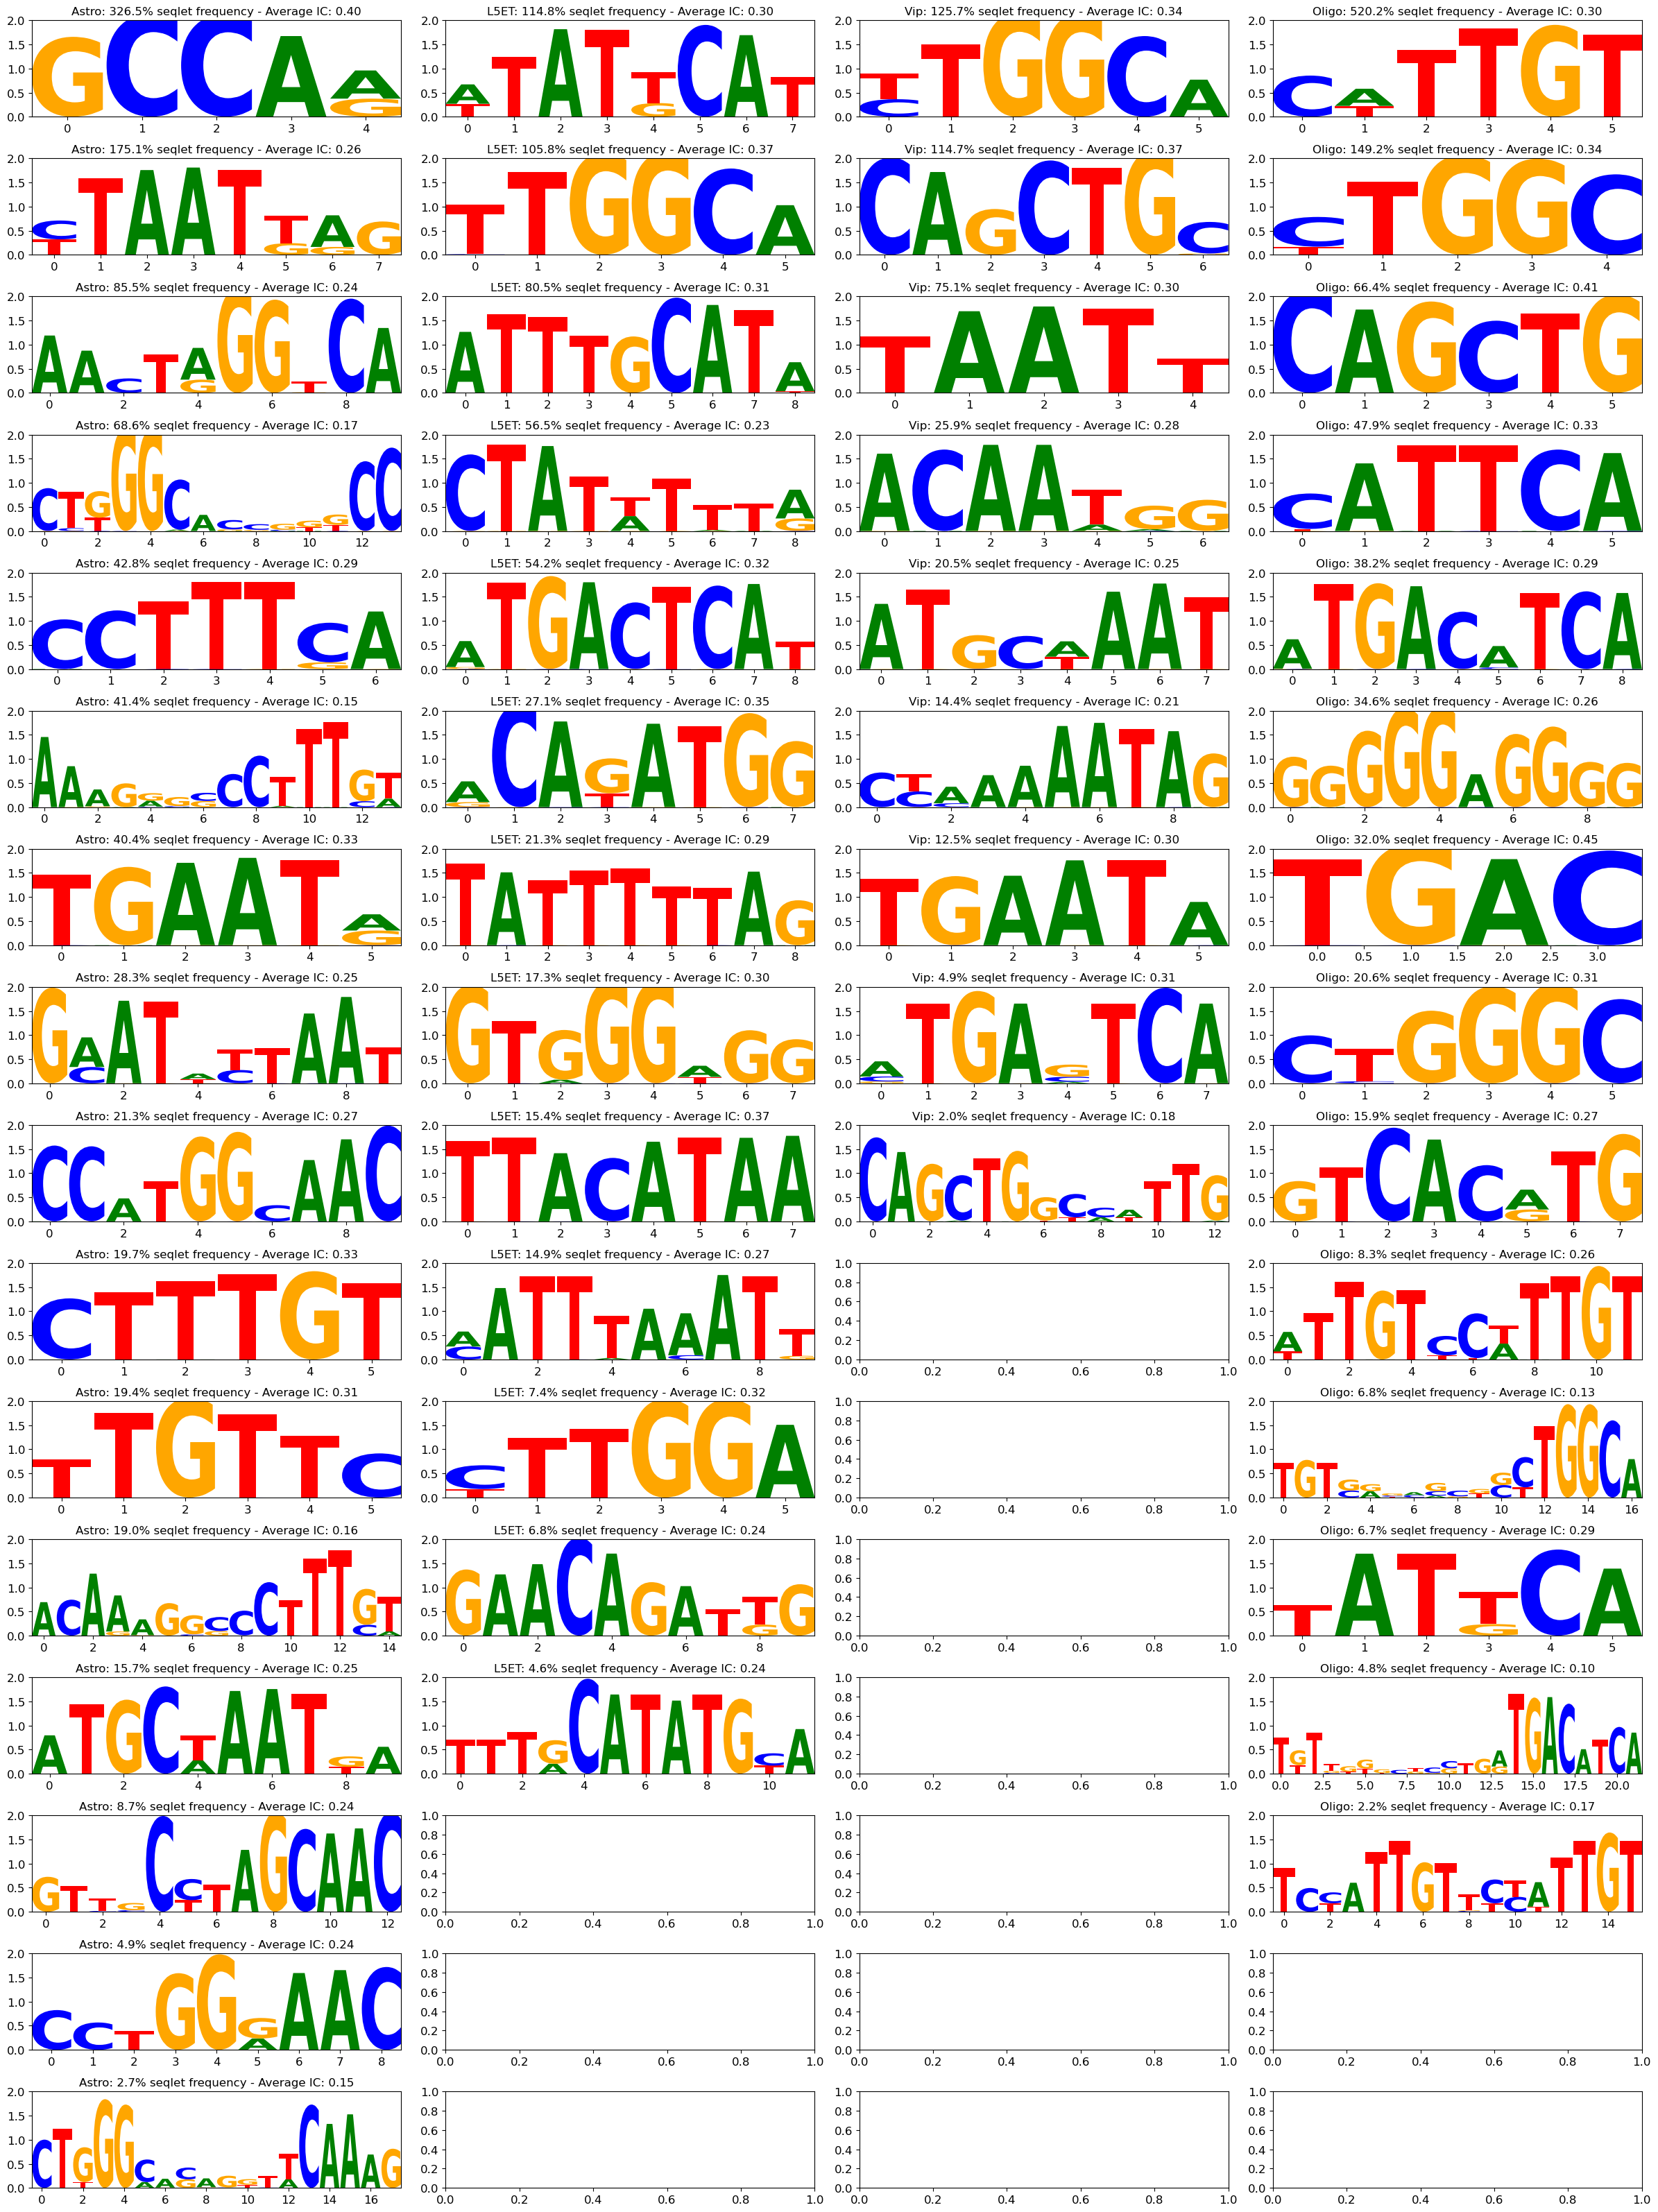

In [18]:
%matplotlib inline
top_k = 1000
crested.pl.patterns.modisco_results(
    classes=["Astro", "L5ET", "Vip", "Oligo"],
    contribution="positive",
    contribution_dir="modisco_results_ft_2000",
    num_seq=top_k,
    y_max=0.15,
    viz="pwm",
)  # You can also visualize in 'pwm' format

### Matching patterns across cell types

Since we have calculated per cell type the patterns independently of each other, we do not know quantitavely how and if they overlap.
It can be interesting to get an overview of which patterns are found across multiple cell types, how important they are, and if there are unique patterns only found in a small selection of classes.
Therefore, we have made a pattern clustering algorithm, which starts from the results of tfmodisco-lite, and return a pattern matrix, which contains the importance of the clustered patterns per cell type, and a pattern dictionary, describing all clustered patterns.

First, we'll obtain the modisco files per class by using {func}`crested.tl.modisco.match_h5_files_to_classes` using our selected classes.
Then, we'll cluster these patterns using {func}`crested.tl.modisco.process_patterns` and create a pattern matrix with {func}`crested.tl.modisco.create_pattern_matrix`

In [19]:
# First we obtain the resulting modisco files per class
matched_files = crested.tl.modisco.match_h5_files_to_classes(
    contribution_dir="modisco_results_ft_2000", classes=list(adata.obs_names)
)

In [20]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=4.25,  # The similarity threshold used for matching patterns. We take the -log10(pval), pval obtained through TOMTOM matching from tangermeme
    trim_ic_threshold=0.05,  # Information content (IC) threshold on which to trim patterns
    discard_ic_threshold=0.2,  # IC threshold used for discarding single instance patterns
    verbose=True,  # Useful for doing sanity checks on matching patterns
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(adata.obs_names),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
pattern_matrix.shape

Reading file modisco_results_ft_2000/Astro_modisco_results.h5
Match between Astro_pos_patterns_1 and Astro_neg_patterns_4 with similarity score 4.83
Match between Astro_pos_patterns_11 and Astro_pos_patterns_5 with similarity score 7.19
Match between Astro_pos_patterns_14 and Astro_pos_patterns_8 with similarity score 4.80
Match between Astro_pos_patterns_15 and Astro_pos_patterns_3 with similarity score 7.44
Reading file modisco_results_ft_2000/Endo_modisco_results.h5
Match between Endo_neg_patterns_0 and Astro_neg_patterns_0 with similarity score 4.44
Match between Endo_pos_patterns_1 and Astro_pos_patterns_3 with similarity score 7.06
Match between Endo_pos_patterns_7 and Astro_neg_patterns_2 with similarity score 5.45
Match between Endo_pos_patterns_11 and Endo_pos_patterns_7 with similarity score 5.20
Reading file modisco_results_ft_2000/L2_3IT_modisco_results.h5
Match between L2_3IT_neg_patterns_2 and Astro_neg_patterns_0 with similarity score 4.79
Match between L2_3IT_neg_patter

(19, 108)

Now we can plot a clustermap of cell types/classes and patterns, where the classes are clustered 
purely on pattern importance with {func}`crested.tl.modisco.generate_nucleotide_sequences` and {func}`crested.pl.patterns.clustermap`

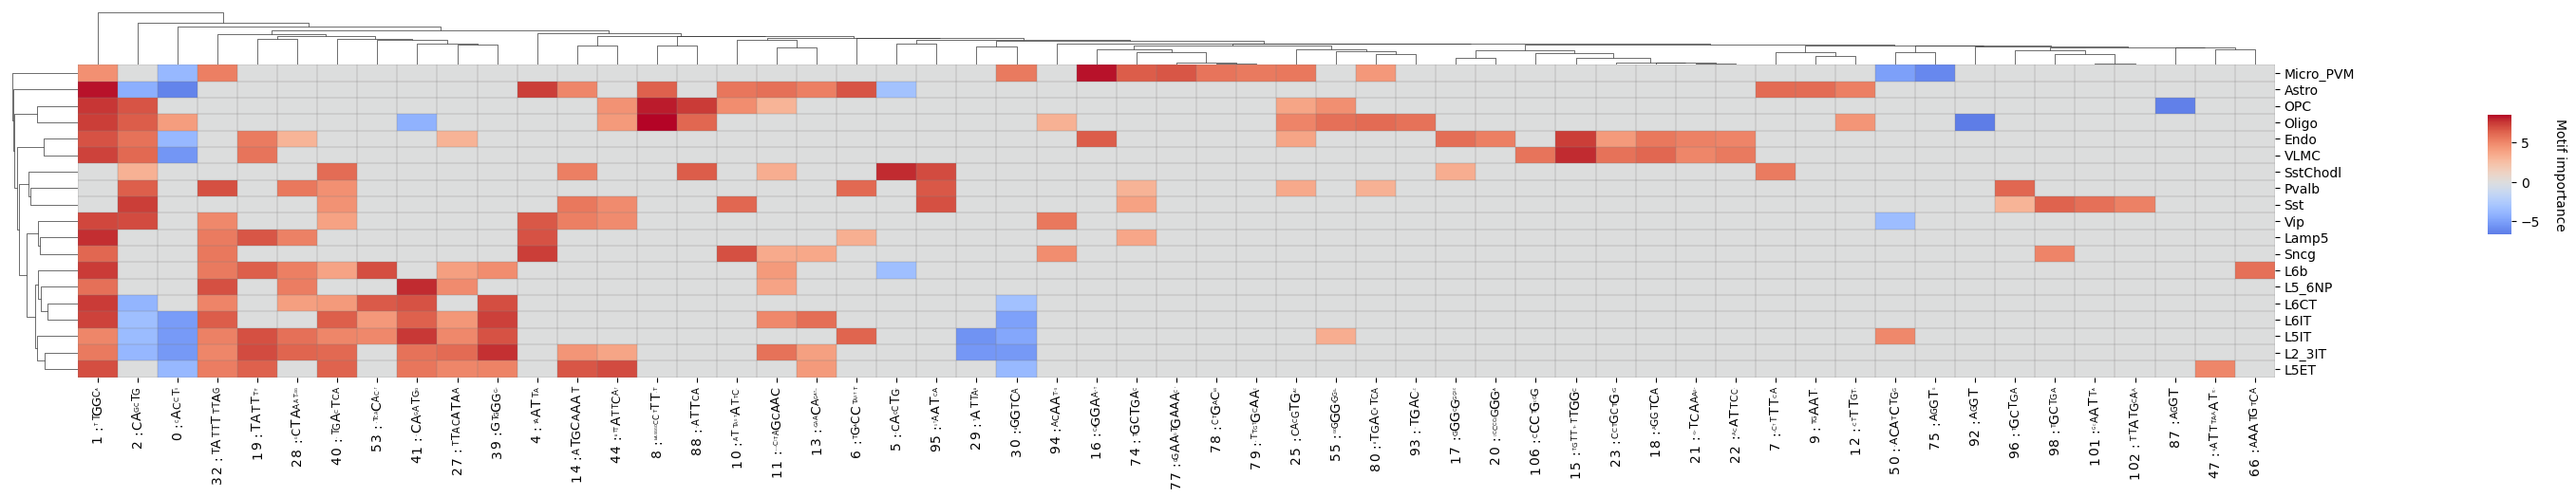

In [22]:
import matplotlib

%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

pat_seqs = crested.tl.modisco.generate_nucleotide_sequences(all_patterns)
crested.pl.patterns.clustermap(
    pattern_matrix,
    list(adata.obs_names),
    figsize=(25, 4.2),
    pat_seqs=pat_seqs,
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5,
)

If you have the horizontal space for it, you can also add the PWM/Contrib logos to the x-axis.

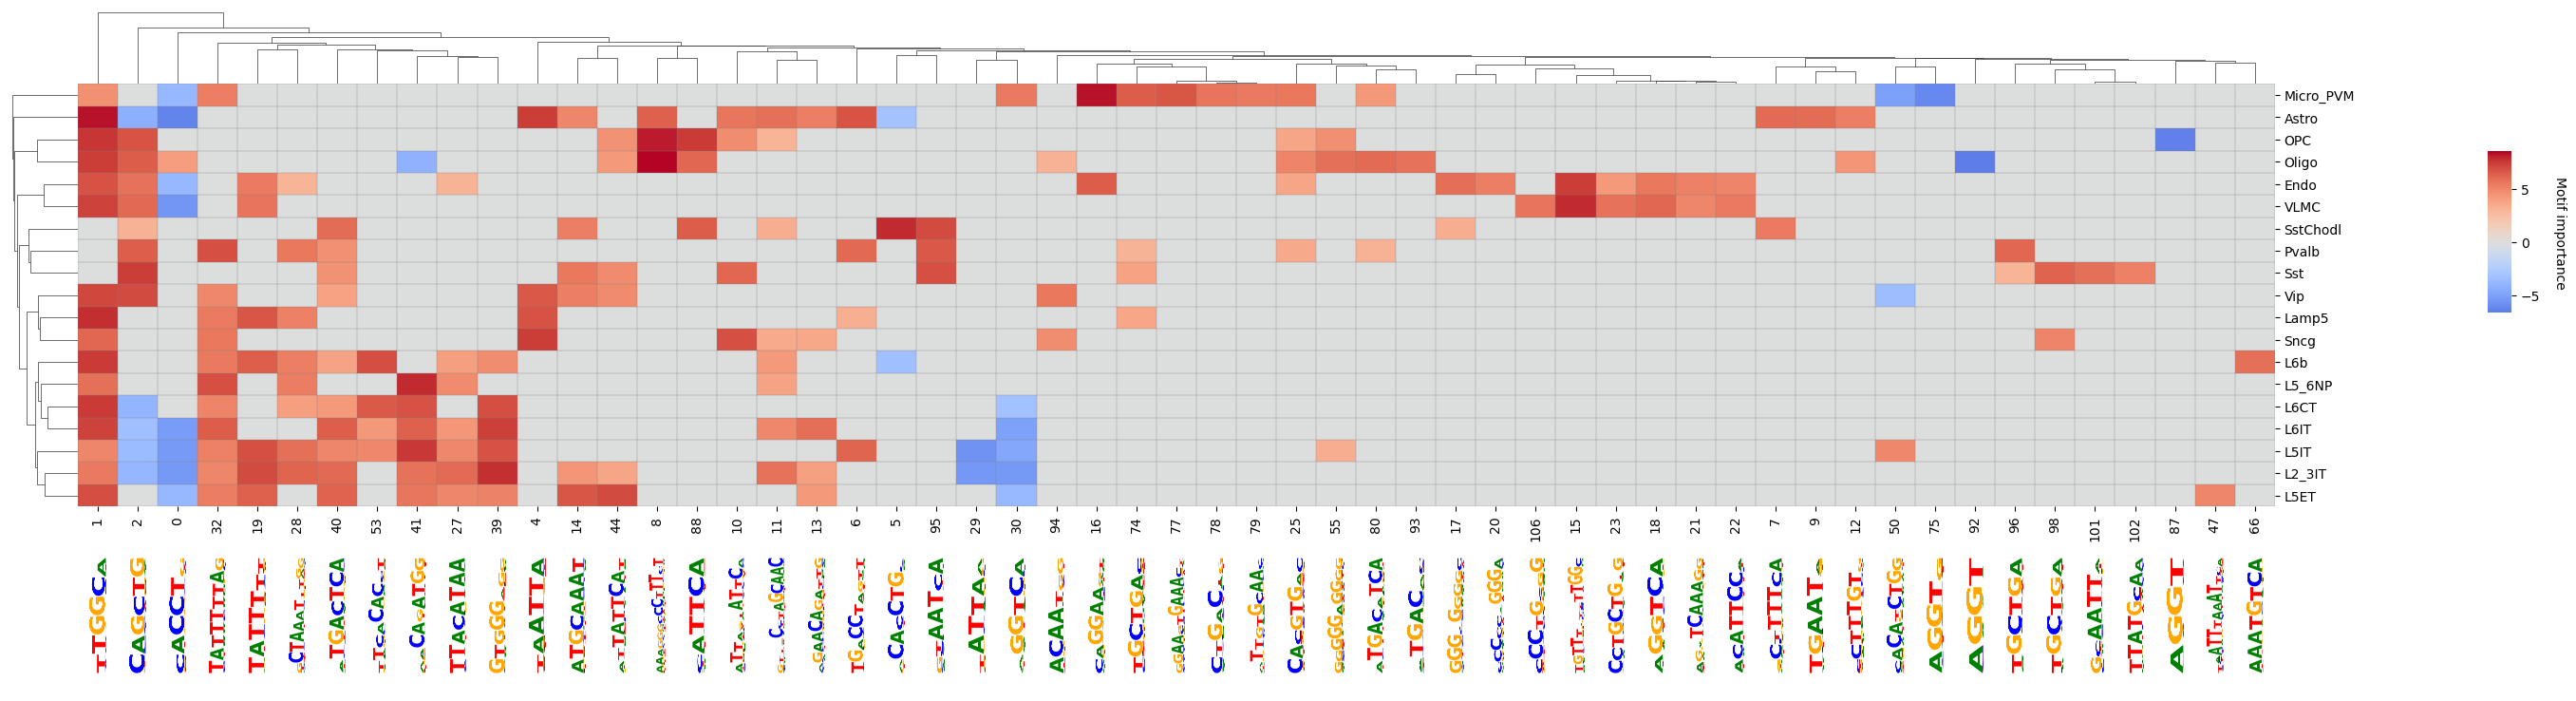

In [23]:
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(adata.obs_names),
    pattern_dict=all_patterns,
    figsize=(25, 4.2),
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5,  # 3.5,
    logo_height_fraction=0.35,
    logo_y_padding=0.25,
)

We can also subset to classes we are interested in and want to compare in more detail.

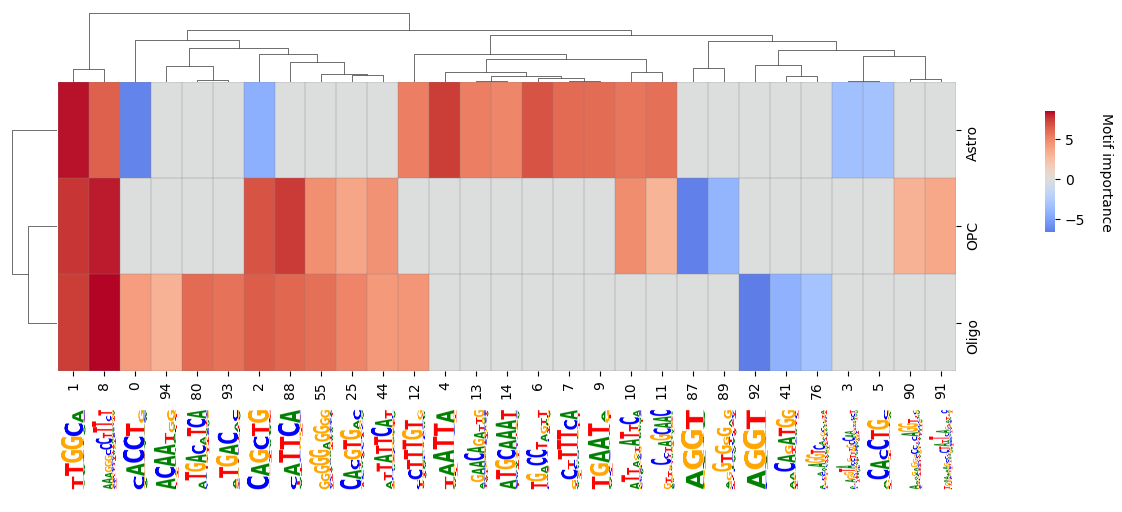

In [30]:
%matplotlib inline
pat_seqs = crested.tl.modisco.generate_nucleotide_sequences(all_patterns)
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    classes=list(adata.obs_names),
    pattern_dict=all_patterns,
    subset=["Astro", "OPC", "Oligo"],
    figsize=(10, 3),
    grid=True,
    logo_height_fraction=0.35,
    logo_y_padding=0.3,
)

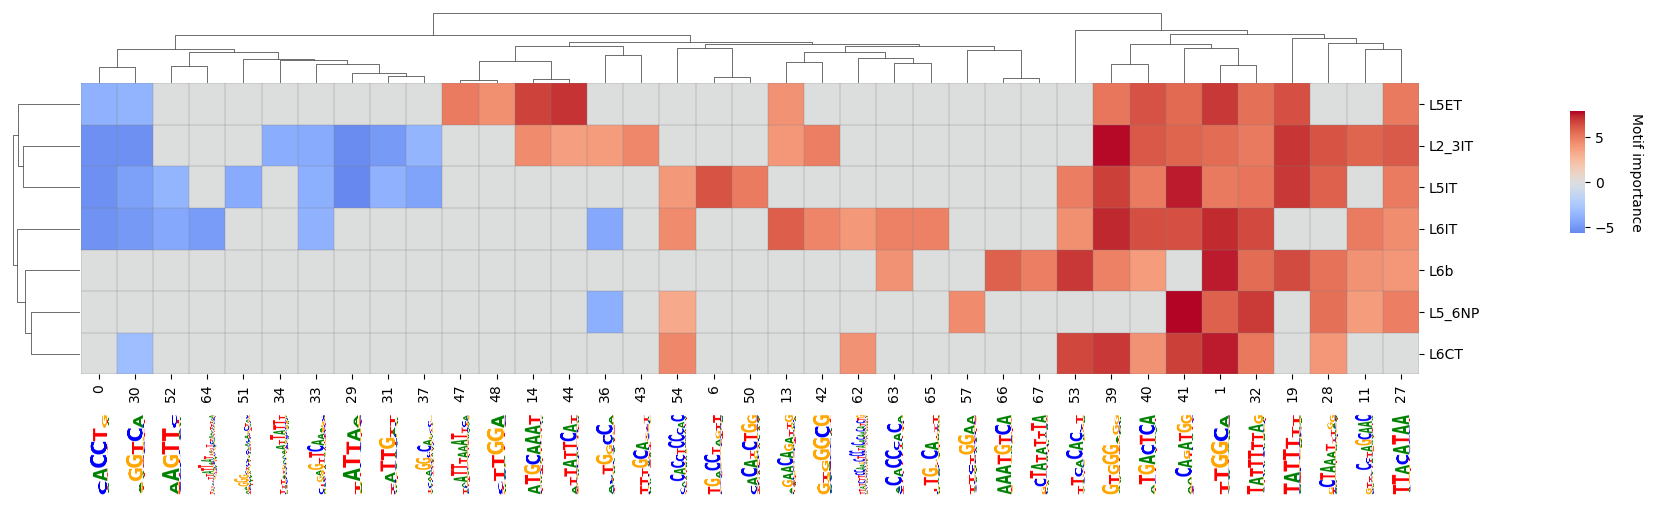

In [33]:
%matplotlib inline
pat_seqs = crested.tl.modisco.generate_nucleotide_sequences(all_patterns)
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    classes=list(adata.obs_names),
    subset=["L2_3IT", "L5ET", "L5IT", "L5_6NP", "L6CT", "L6IT", "L6b"],
    pattern_dict=all_patterns,
    figsize=(15, 3),
    grid=True,
    logo_height_fraction=0.35,
    logo_y_padding=0.3,
    importance_threshold=4,
)

#### Additional pattern insights

It is always interesting to investigate specific patterns show in the clustermap above. Here there are some example function on how to do that.

Plotting patterns based on their indices can be done with {func}`crested.pl.patterns.selected_instances`

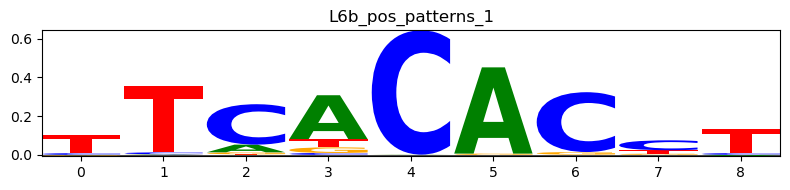

In [34]:
pattern_indices = [53]
crested.pl.patterns.selected_instances(
    all_patterns, pattern_indices
)  # The pattern that is shown is the most representative pattern of the cluster with the highest average IC

We can also do a check of pattern similarity

Pattern similarity is tensor(0.2183, dtype=torch.float64)


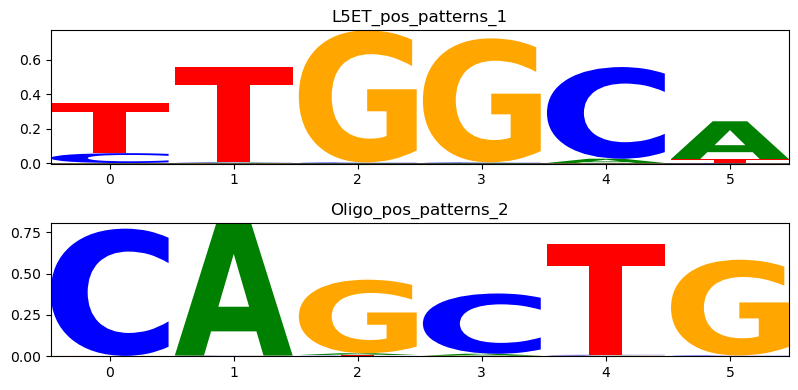

In [36]:
idx1 = 1
idx2 = 2
sim = crested.tl.modisco.pattern_similarity(all_patterns, idx1, idx2)
print("Pattern similarity is " + str(sim))
crested.pl.patterns.selected_instances(all_patterns, [idx1, idx2])

We can plot all the instances of patterns in the same cluster with {func}`crested.pl.patterns.class_instances`

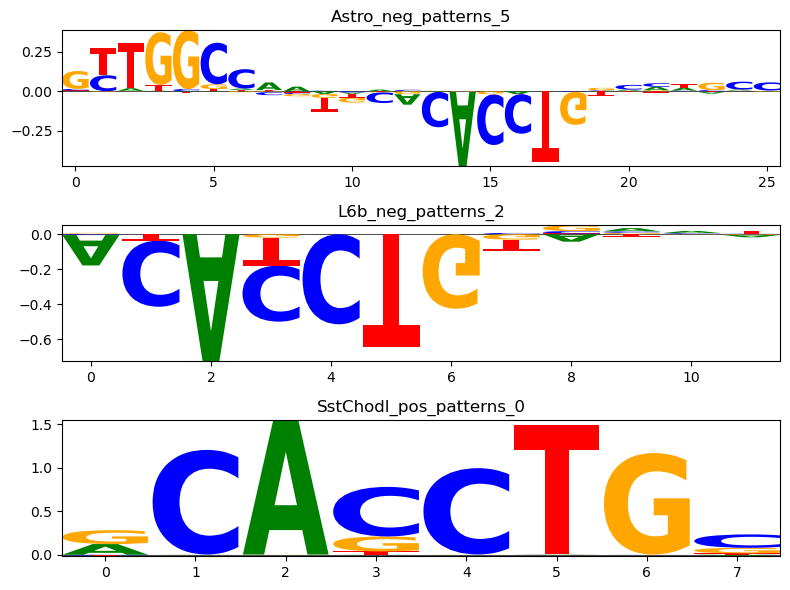

In [37]:
crested.pl.patterns.class_instances(all_patterns, 5)

If you want to find out in which pattern cluster a certain pattern is from your modisco results, you can call the {func}`crested.tl.modisco.find_pattern` function.

Pattern index is 87


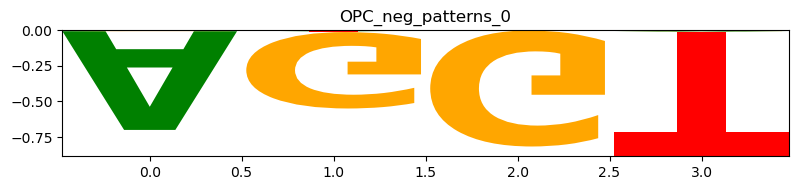

In [38]:
idx = crested.tl.modisco.find_pattern("OPC_neg_patterns_0", all_patterns)
if idx is not None:
    print("Pattern index is " + str(idx))
    crested.pl.patterns.class_instances(all_patterns, idx, class_representative=True)

Finally we can also plot the similarity between all patterns with {func}`crested.tl.modisco.calculate_similarity_matrix` and {func}`crested.pl.patterns.similarity_heatmap`

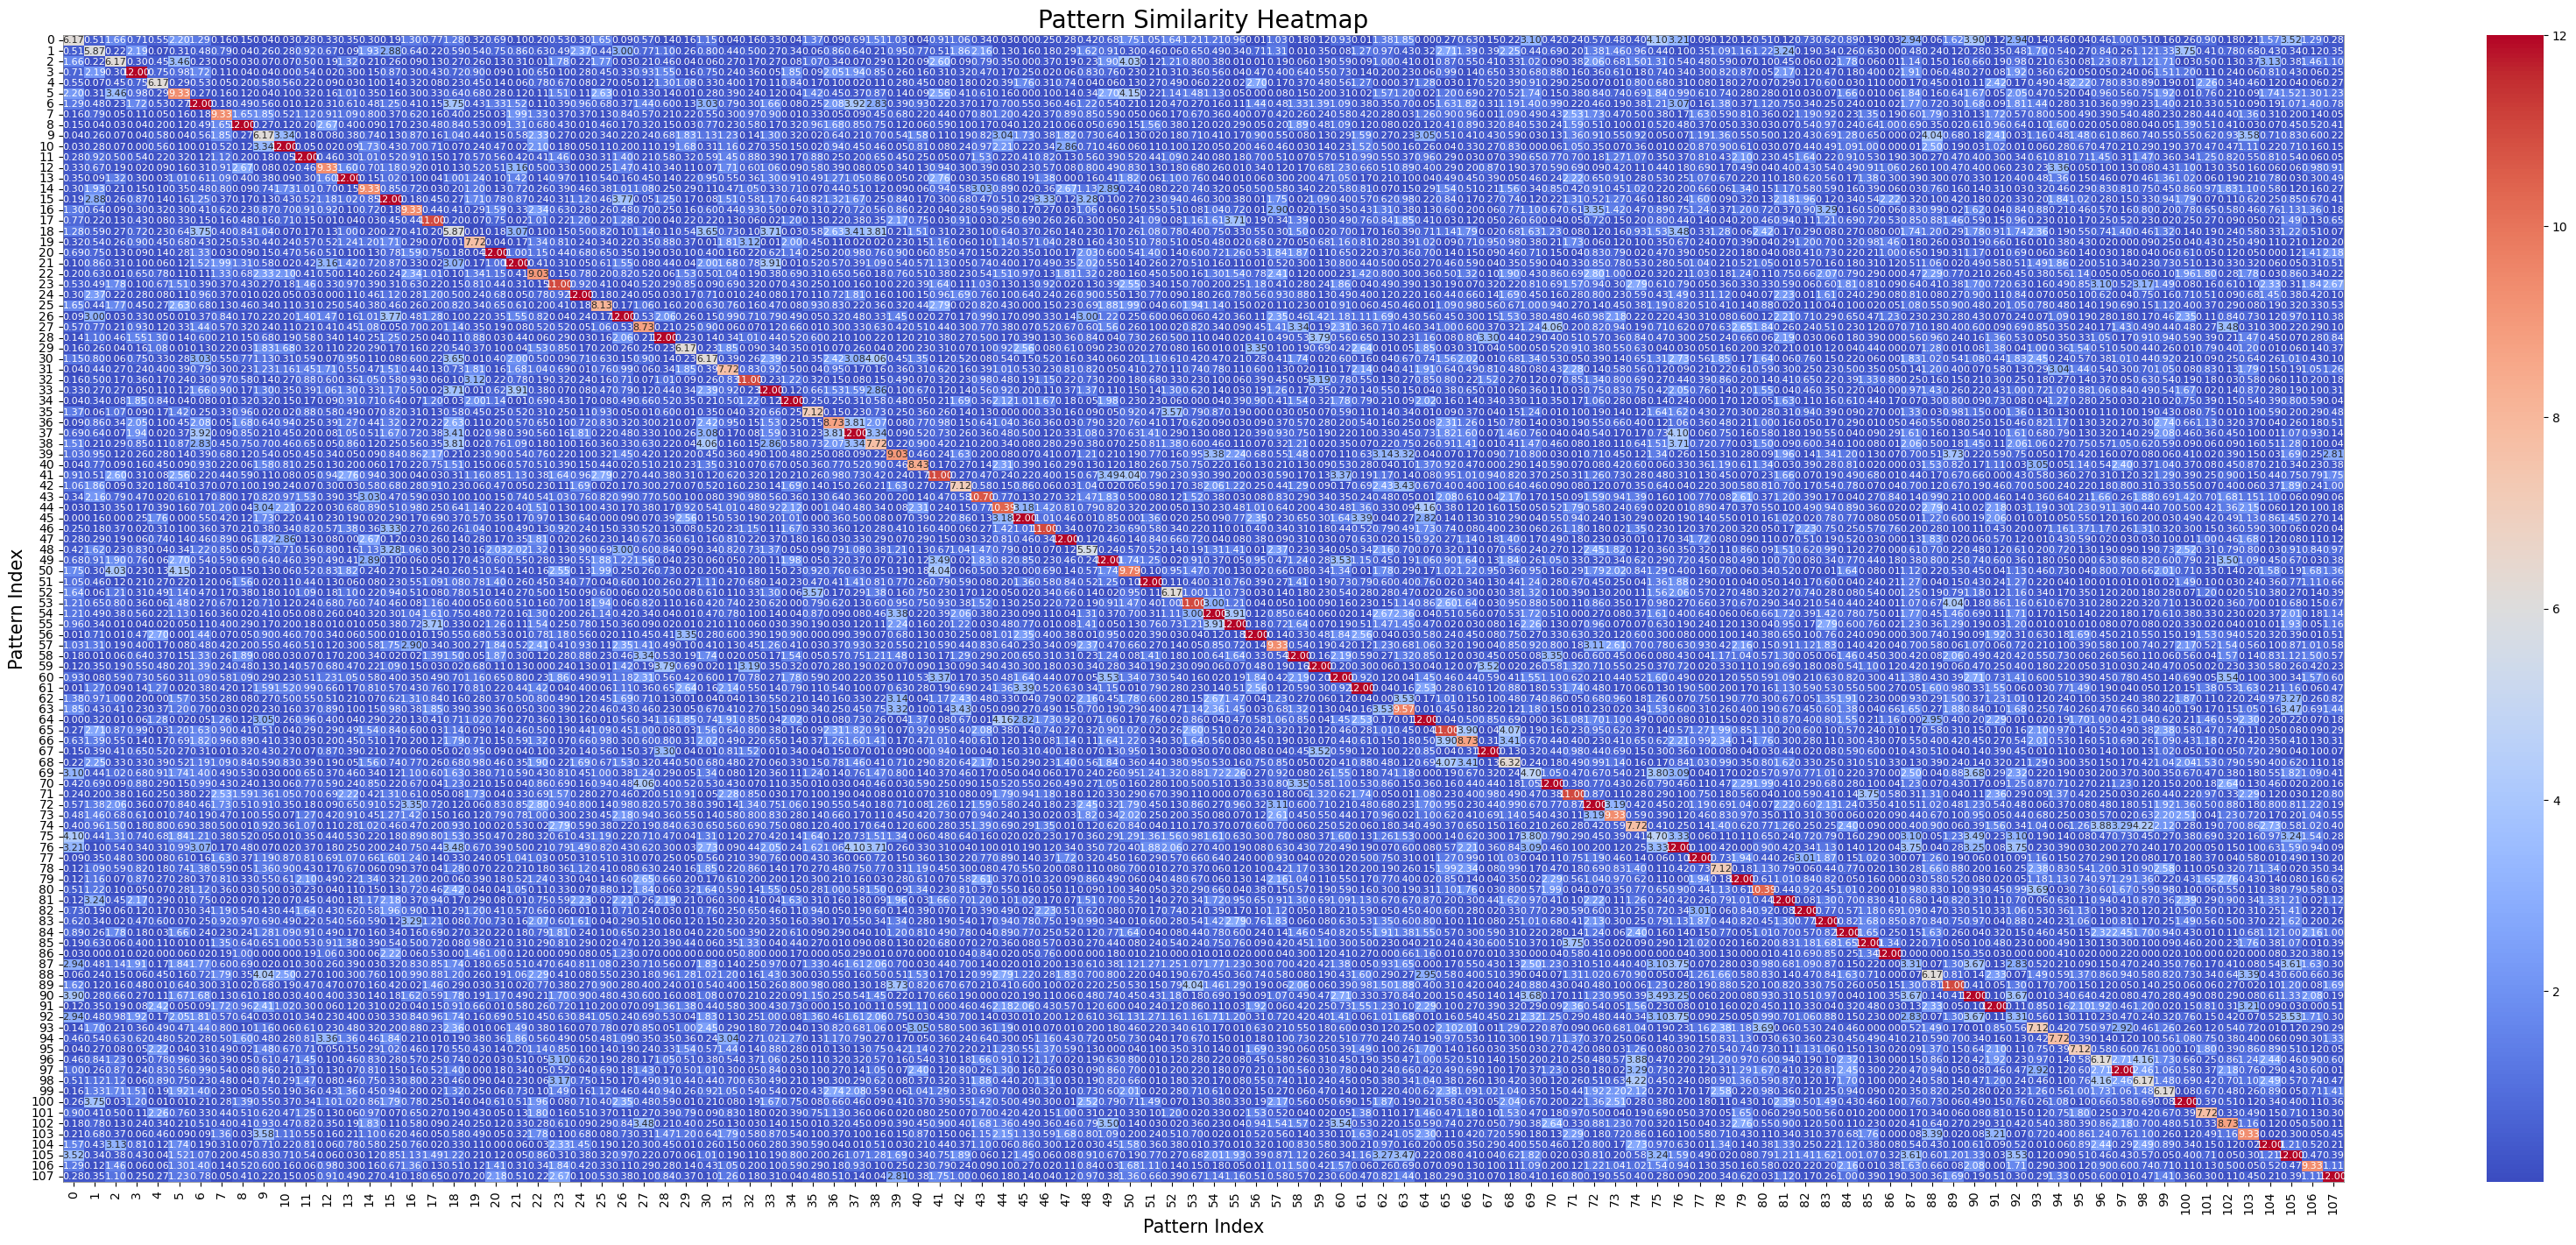

In [39]:
sim_matrix, indices = crested.tl.modisco.calculate_similarity_matrix(all_patterns)
crested.pl.patterns.similarity_heatmap(sim_matrix, indices, fig_size=(42, 17))

### Matching patterns to TF candidates from scRNA-seq data [Optional]

To understand the actual transcription factor (TF) candidates binding to the characteristic patterns/potential binding sites per cell type, we can propose potential candidates through scRNA-seq data and a TF-motif collection file.

**This analysis requires that you ran tfmodisco-lite with the report function such that each pattern has potential MEME database hits and that you have multiome data.**
The names in the motif database should match those in the TF-motif collection file.

#### Load scRNA-seq data

Load scRNA seq data and calculate mean expression per cell type using {func}`crested.tl.modisco.calculate_mean_expression_per_cell_type`

In [41]:
import crested

file_path = (
    "../../../../mouse/biccn/Mouse_rna.h5ad"  # Locate h5 file containing scRNAseq data
)
cell_type_column = "subclass_Bakken_2022"
mean_expression_df = crested.tl.modisco.calculate_mean_expression_per_cell_type(
    file_path, cell_type_column, cpm_normalize=True
)

/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages/crested/tl/modisco/_tfmodisco.py:1390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression_per_cell_type: pd.DataFrame = gene_expression_df.groupby(


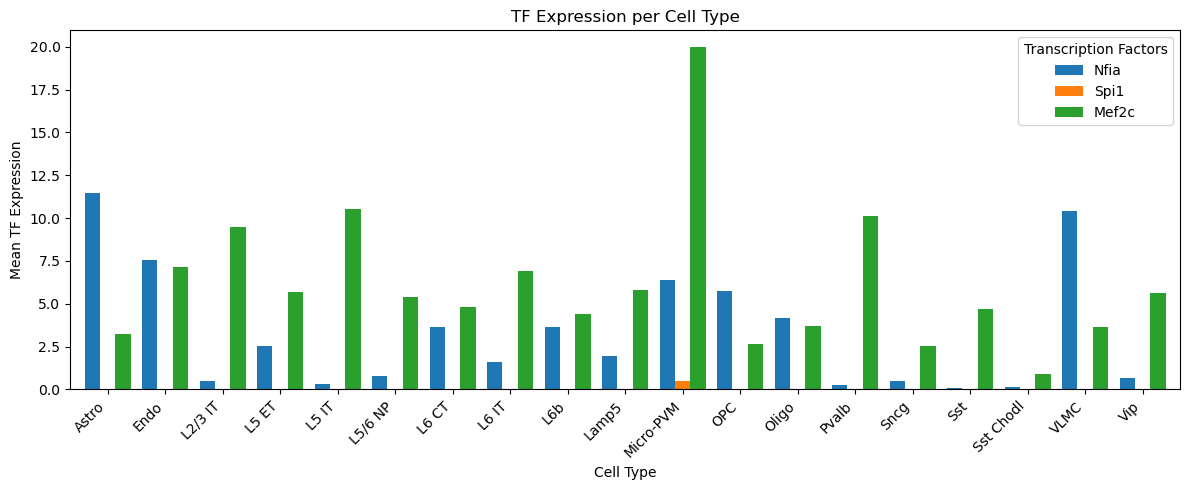

In [42]:
crested.pl.patterns.tf_expression_per_cell_type(
    mean_expression_df, ["Nfia", "Spi1", "Mef2c"]
)

#### Generating pattern to database motif dictionary

In [43]:
classes = list(adata.obs_names)
contribution_dir = "modisco_results_ft_2000"
html_paths = crested.tl.modisco.generate_html_paths(
    all_patterns, classes, contribution_dir
)

pattern_match_dict = crested.tl.modisco.find_pattern_matches(
    all_patterns, html_paths, q_val_thr=0.05
)  # q_val threshold to only select significant matches

#### Loading TF-motif database

In [44]:
motif_to_tf_df = crested.tl.modisco.read_motif_to_tf_file(
    "../../../../tools/Motif_collection.tsv"
)
motif_to_tf_df

logo  \
0                                <img src="https://motifcollections.aertslab.org/v10/logos/bergman__Adf1.png" height="52" alt="bergman__Adf1"></img>   
1                                <img src="https://motifcollections.aertslab.org/v10/logos/bergman__Aef1.png" height="52" alt="bergman__Aef1"></img>   
2                                    <img src="https://motifcollections.aertslab.org/v10/logos/bergman__ap.png" height="52" alt="bergman__ap"></img>   
3                        <img src="https://motifcollections.aertslab.org/v10/logos/elemento__ACCTTCA.png" height="52" alt="elemento__ACCTTCA"></img>   
4                                  <img src="https://motifcollections.aertslab.org/v10/logos/bergman__bcd.png" height="52" alt="bergman__bcd"></img>   
...                                                                                                                                              ...   
22471                    <img src="https://motifcollections.aertslab.org/v10/logos/elemento__CAAGGAG.png" height="52" alt="elemento__CAAGGAG"></img>   
22472                    <img src="https://motifcollections.aertslab.org/v10/logos/elemento__TCCTTGC.png" height="52" alt="elemento__TCCTTGC"></img>   
22473      <img src="https://motifcollections.aertslab.org/v10/logos/swissregulon__hs__ZNF274.png" height="52" alt="swissregulon__hs__ZNF274"></img>   
22474  <img src="https://motifcollections.aertslab.org/v10/logos/swissregulon__sacCer__THI2.png" height="52" alt="swissregulon__sacCer__THI2"></img>   
22475                      <img src="https://motifcollections.aertslab.org/v10/logos/jaspar__MA0407.1.png" height="52" alt="jaspar__MA0407.1"></img>   

                       Motif_name  Cluster Human_Direct_annot  \
0                   bergman__Adf1      NaN                NaN   
1                   bergman__Aef1      NaN                NaN   
2                     bergman__ap      NaN                NaN   
3               elemento__ACCTTCA      NaN                NaN   
4                    bergman__bcd      NaN                NaN   
...                           ...      ...                ...   
22471           elemento__CAAGGAG     98.3                NaN   
22472           elemento__TCCTTGC     98.3                NaN   
22473    swissregulon__hs__ZNF274     99.1             ZNF274   
22474  swissregulon__sacCer__THI2     99.2                NaN   
22475            jaspar__MA0407.1     99.2                NaN   

      Human_Orthology_annot Mouse_Direct_annot Mouse_Orthology_annot  \
0                       NaN                NaN                   NaN   
1                       NaN                NaN                   NaN   
2                       NaN                NaN                   NaN   
3                       NaN                NaN                   NaN   
4                       NaN                NaN                   NaN   
...                     ...                ...                   ...   
22471                   NaN                NaN                   NaN   
22472                   NaN                NaN                   NaN   
22473                   NaN                NaN        Zfp369, Zfp110   
22474                   NaN                NaN                   NaN   
22475                   NaN                NaN                   NaN   

      Fly_Direct_annot Fly_Orthology_annot Cluster_Human_Direct_annot  \
0                 Adf1                 NaN                        NaN   
1                 Aef1                 NaN                        NaN   
2                   ap                 NaN                        NaN   
3                  NaN                 NaN                        NaN   
4                  bcd                 NaN                        NaN   
...                ...                 ...                        ...   
22471              NaN                 NaN                        NaN   
22472              NaN                 NaN                        NaN   
22473           

#### Matching patterns to TF candidates

We calculate a pattern-tf by cell type matrix which contains the imporatance of each pattern linked to a TF per cell type using {func}`crested.tl.modisco.create_pattern_tf_dict` and {func}`crested.tl.modisco.create_tf_ct_matrix`

In [46]:
cols = [
    "Mouse_Direct_annot",
    "Mouse_Orthology_annot",
    "Cluster_Mouse_Direct_annot",
    "Cluster_Mouse_Orthology_annot",
]
pattern_tf_dict, all_tfs = crested.tl.modisco.create_pattern_tf_dict(
    pattern_match_dict, motif_to_tf_df, all_patterns, cols
)
tf_ct_matrix, tf_pattern_annots = crested.tl.modisco.create_tf_ct_matrix(
    pattern_tf_dict,
    all_patterns,
    mean_expression_df,
    classes,
    log_transform=True,
    normalize_pattern_importances=False,
    normalize_gex=True,
    min_tf_gex=0.95,
    importance_threshold=5.5,
    pattern_parameter="seqlet_count_log",
    filter_correlation=True,
    verbose=True,
    zscore_threshold=1.5,
    correlation_threshold=0.35,
)

Total columns before threshold filtering: 989
Total columns after threshold filtering: 149
Total columns removed: 840
Total columns before correlation filtering: 149
Total columns after correlation filtering: 103
Total columns removed: 46


Finally, we can plot a clustermap of potential pattern-TF matches and their importance per cell type with {func}`crested.pl.patterns.clustermap_tf_motif`

/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages/crested/pl/patterns/_modisco_results.py:897: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


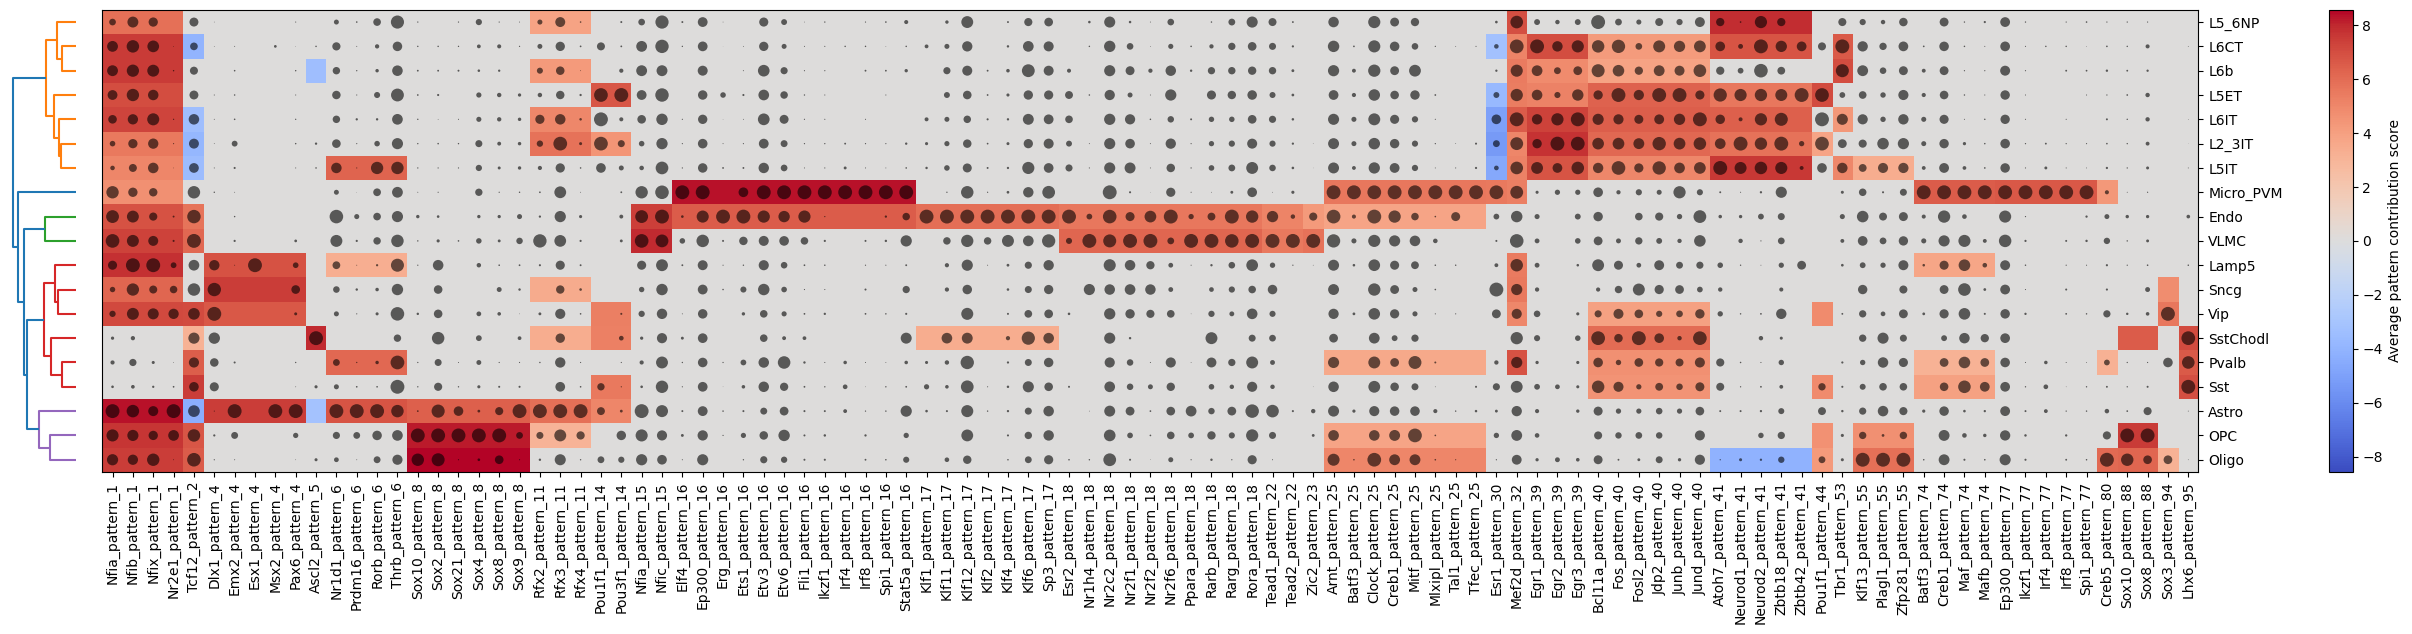

In [47]:
crested.pl.patterns.clustermap_tf_motif(
    tf_ct_matrix,
    heatmap_dim="contrib",
    dot_dim="gex",
    class_labels=classes,
    pattern_labels=tf_pattern_annots,
    fig_size=(35, 6),
    cluster_rows=True,
    cluster_columns=False,
)

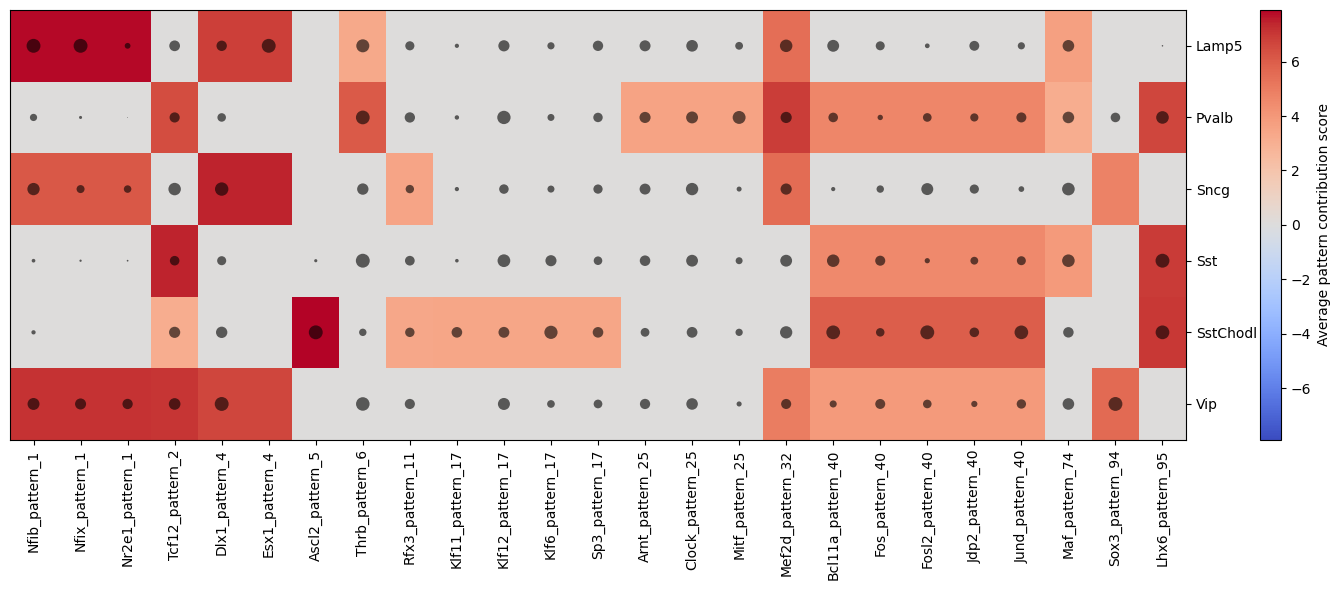

In [48]:
crested.pl.patterns.clustermap_tf_motif(
    tf_ct_matrix,
    heatmap_dim="contrib",
    dot_dim="gex",
    class_labels=classes,
    subset_classes=["Lamp5", "Sncg", "Vip", "Pvalb", "Sst", "SstChodl"],
    pattern_labels=tf_pattern_annots,
    fig_size=(15, 6),
    cluster_rows=False,
    cluster_columns=False,
)